In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras import layers
from keras.layers import Dropout

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [2]:
TRIM_LENGTH = 300 #Number of first 'n' words after which the text should be trimmed.
TRAIN_TEST_SPLIT = 0.95
TRAIN_VALID_SPLIT = 0.80

In [3]:
data_ = pd.read_csv("news.csv", index_col=0)

In [4]:
def encodeLabels(dafr, label_col):
    df = dafr.copy()
    encoder = LabelEncoder()
    encoder.fit(df[label_col])
    df[label_col] = encoder.transform(df[label_col])
    return(df, encoder)

In [5]:
def trainvalidtestSplit(df, encoder):
    
    def dfSplitter(df, split):
        return(train_test_split(df, train_size=split, shuffle=True))
    
    fake_index, real_index = list(encoder.classes_).index("FAKE"), list(encoder.classes_).index("REAL")
    
    df_fake, df_real = df[df.label == fake_index], df[df.label == real_index]
    
    df_real_full_train, df_real_test = dfSplitter(df_real, TRAIN_TEST_SPLIT)
    df_fake_full_train, df_fake_test = dfSplitter(df_fake, TRAIN_TEST_SPLIT)
    
    df_real_train, df_real_valid = dfSplitter(df_real_full_train, TRAIN_VALID_SPLIT)
    df_fake_train, df_fake_valid = dfSplitter(df_fake_full_train, TRAIN_VALID_SPLIT)
    
    df_train = pd.concat([df_real_train, df_fake_train], ignore_index=True, sort=False)
    df_valid = pd.concat([df_real_valid, df_fake_valid], ignore_index=True, sort=False)
    df_test = pd.concat([df_real_test, df_fake_test], ignore_index=True, sort=False)
    
    return (df_train, df_valid, df_test)

In [6]:
data_["titletext"] = data_.title + '. ' + data_.text

In [7]:
encoded_data, label_encoding = encodeLabels(data_, "label")

In [8]:
train_, valid_, test_ = trainvalidtestSplit(encoded_data, label_encoding)

In [9]:
corpus = data_["titletext"]
vectorizer = CountVectorizer(min_df=0, lowercase=False, stop_words='english')
vectorizer.fit(corpus)

CountVectorizer(lowercase=False, min_df=0, stop_words='english')

In [10]:
X_train = vectorizer.transform(train_['titletext'])
X_valid = vectorizer.transform(valid_['titletext'])
X_test = vectorizer.transform(test_['titletext'])

Y_train = train_['label']
Y_valid = valid_['label']
Y_test = test_['label']

In [11]:
input_dim = X_train.toarray().shape[1]

In [12]:
model = Sequential()
model.add(layers.Dense(50, input_dim=input_dim, activation='selu'))
model.add(Dropout(0.2))
model.add(layers.Dense(50, input_dim=50, activation='selu'))
model.add(Dropout(0.2))
model.add(layers.Dense(50, input_dim=50, activation='selu'))
model.add(Dropout(0.2))
model.add(layers.Dense(25, input_dim=50, activation='selu'))
model.add(Dropout(0.2))
model.add(layers.Dense(5, input_dim=25, activation='selu'))
model.add(Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))

In [13]:
model.compile(loss='binary_crossentropy',
              optimizer='adam', 
              metrics=['accuracy'])

In [14]:
history = model.fit(X_train.toarray(), Y_train,
                    epochs=5,
                    verbose=True,
                    validation_data=(X_valid.toarray(), Y_valid),
                    batch_size=10)

Epoch 1/5
482/482 [==============================] - 11s 22ms/step - loss: 0.4276 - accuracy: 0.8357 - val_loss: 0.1802 - val_accuracy: 0.9410
Epoch 2/5
482/482 [==============================] - 9s 19ms/step - loss: 0.0760 - accuracy: 0.9769 - val_loss: 0.2284 - val_accuracy: 0.9402
Epoch 3/5
482/482 [==============================] - 9s 19ms/step - loss: 0.0246 - accuracy: 0.9944 - val_loss: 0.3104 - val_accuracy: 0.9419
Epoch 4/5
482/482 [==============================] - 9s 19ms/step - loss: 0.0174 - accuracy: 0.9955 - val_loss: 0.3306 - val_accuracy: 0.9419
Epoch 5/5
482/482 [==============================] - 9s 18ms/step - loss: 0.0100 - accuracy: 0.9978 - val_loss: 0.3883 - val_accuracy: 0.9377


In [15]:
Y_test_pred = np.squeeze(np.round(model.predict(X_test.toarray())))

In [16]:
print(classification_report(Y_test.to_numpy(), Y_test_pred, target_names=list(label_encoding.classes_)))

              precision    recall  f1-score   support

        FAKE       0.93      0.97      0.95       159
        REAL       0.97      0.92      0.95       159

    accuracy                           0.95       318
   macro avg       0.95      0.95      0.95       318
weighted avg       0.95      0.95      0.95       318



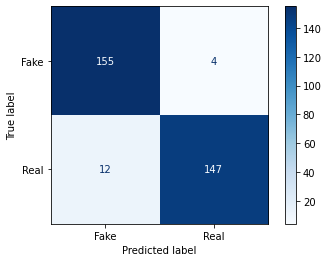

In [17]:
cm = confusion_matrix(Y_test.to_numpy(), Y_test_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["Fake","Real"])
disp.plot(cmap=plt.cm.Blues)
plt.show()